<a href="https://colab.research.google.com/github/Danicoder/Especializacion_IA_BigData/blob/main/6-3.Redes%20convolucionales_clasificador%20de%20im%C3%A1genes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import tensorflow as tf
import keras
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras import Sequential
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [31]:
# Descargar y extraer el dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, cache_dir='.', untar=True) #untar=True creó una subcarpeta adicional llamada flower_photos
data_dir = os.path.join(os.path.dirname(data_dir), 'flower_photos')  # Obtener ruta correcta

In [32]:
# Verificar si la carpeta "flower_photos" existe dentro del directorio de datos
flower_photos_dir = os.path.join(data_dir, "flower_photos")

# Actualizar data_dir para que apunte a flower_photos si existe
if os.path.exists(flower_photos_dir):
    data_dir = flower_photos_dir  # Actualizamos a la ruta correcta
    print("Ruta actualizada a:", data_dir)
else:
    print("La carpeta 'flower_photos' no existe en el directorio de datos.")

Ruta actualizada a: ./datasets/flower_photos/flower_photos


In [42]:
# Parámetros del dataset
batch_size = 32
img_height = 180
img_width = 180

# Configurar ImageDataGenerator para cargar imágenes por lotes
# ImageDataGenerator para entrenamiento y validación (con división de 80% y 20%)
train_datagen = ImageDataGenerator(rescale=1.0/255., validation_split=0.2)
# ImageDataGenerator para test (con división de 20%)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training' # División para entrenamiento (80%)
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation' # División para validación (20%)
)
# Para el conjunto de test, no usamos subset ni validation_split
test_generator =  test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
Found 3670 images belonging to 5 classes.


#ENTRENAMIENTO DEL MODELO Y AJUSTE

Data augmentation

In [56]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", # Volteo aleatorio
        input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.5), # Rotación aleatoria (hasta 288°)
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.5)                   # Ajuste de brillo aleatorio (mas o menos 20%)
  ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


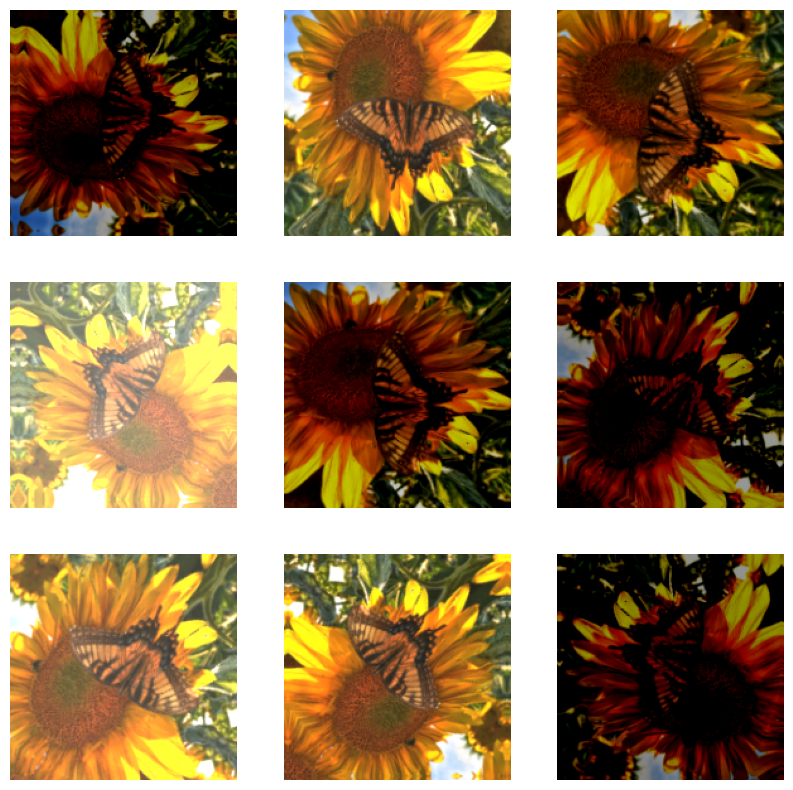

In [57]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Transfer Learning (Aumenta la presición del la red)

In [83]:
model2 = VGG16(
    input_shape = (
        img_height,img_width,3),  # Tamaño de la imágen de entrada con 180 canales * 3 (rojo,verde y azul)
        include_top=False,        # excluye la capa final
        weights = 'imagenet')     # conjunto de datos

model2.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Capas

In [65]:
"""model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5, name="outputs")
])"""

model = Sequential()
model.add(data_augmentation)
# Capa Convolucional 1
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2, 2)))

# Capa Convolucional 2
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Capa Convolucional 3
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Aplanar las características
model.add(Flatten())

# Capa densa de salida
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))


model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 87, 87, 64)          │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,637,957 (25.32 MB)

 Trainable params: 6,637,957 (25.32 MB)

 Non-trainable params: 0 (0.00 B)

Callbacks

In [44]:
# Definir el callback para guardar el mejor modelo
checkpoint_keras = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',              # Nombre del archivo para el formato .keras
    monitor='val_loss',              # Métrica a monitorear
    save_best_only=True,             # Solo guarda el modelo si es el mejor
    save_weights_only=False,         # Guarda todo el modelo (estructura y pesos)
    mode='min',                      # Mejor si el valor monitoreado disminuye
    verbose=1
)

checkpoint_h5 = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',                # Nombre del archivo para el formato .h5
    monitor='val_loss',             # Monitorea la pérdida de validación
    save_best_only=True,            # Solo guarda el mejor modelo
    save_weights_only=False,        # Guarda todo el modelo (estructura y pesos)
    mode='min',                     # Mejor si la pérdida disminuye
    verbose=1
)


Compilar modelo

In [67]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(#optimizer=RMSprop(learning_rate=1e-4),
              optimizer=optimizer,
              loss='binary_crossentropy',
              metrics = ['accuracy'])

Entrenar modelo

In [68]:
history = model.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator,
      verbose=1,
      callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6),
        checkpoint_keras,
        checkpoint_h5
      ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2039 - loss: 1.4627
Epoch 1: val_loss improved from inf to 0.52974, saving model to best_model.keras

Epoch 1: val_loss improved from inf to 0.52974, saving model to best_model.h5


TypeError: cannot pickle 'module' object

Evaluo el modelo

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test loss: {test_loss}") #valor de perdida
print(f"Test accuracy: {test_acc}") #precisión


Visualizar las Curvas de accuracy y val_accuracy

In [ ]:
# Graficar la precisión y la precisión de validación
plt.figure(figsize=(8, 6))

# Accuracy de entrenamiento
plt.plot(history.history['accuracy'], label='Training accuracy')

# Accuracy de validación
plt.plot(history.history['val_accuracy'], label='Validation accuracy')

# Añadir etiquetas
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Mostrar la gráfica
plt.show()

Guardo el modelo

In [ ]:
model.save('modelo_entrenado.h5')

Fine-Tuning: Descongelar Capas del Modelo Base

In [80]:
# Especifica el número de etiquetas en la base convulsional.
vgg16_conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

vgg16_conv_base.trainable = True

# Define TrainingConfig as a simple class to hold configuration
class TrainingConfig:
    LAYERS_FINE_TUNE = 8

num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(vgg16_conv_base.layers)

# Congelamos las capas que no vamos a entrenar
for layer in vgg16_conv_base.layers[:num_layers - num_layers_fine_tune]:
    print(f"FREEZING LAYER: {layer}")
    layer.trainable = False

print("\n")
print(f"Configured to fine tune the last {num_layers_fine_tune} layers of the base model.")
print("\n")

# Verificamos el estado de las capas
print(vgg16_conv_base.summary())



FREEZING LAYER: <InputLayer name=input_layer_11, built=True>
FREEZING LAYER: <Conv2D name=block1_conv1, built=True>
FREEZING LAYER: <Conv2D name=block1_conv2, built=True>
FREEZING LAYER: <MaxPooling2D name=block1_pool, built=True>
FREEZING LAYER: <Conv2D name=block2_conv1, built=True>
FREEZING LAYER: <Conv2D name=block2_conv2, built=True>
FREEZING LAYER: <MaxPooling2D name=block2_pool, built=True>
FREEZING LAYER: <Conv2D name=block3_conv1, built=True>
FREEZING LAYER: <Conv2D name=block3_conv2, built=True>
FREEZING LAYER: <Conv2D name=block3_conv3, built=True>
FREEZING LAYER: <MaxPooling2D name=block3_pool, built=True>


Configured to fine tune the last 8 layers of the base model.




Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 12,979,200 (49.51 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

None
